In [1]:
import numpy as np
import pycolmap
import torch
import torch.nn as nn

from splat.gaussians import Gaussians
from splat.utils import read_images_binary, read_images_text

colmap_path = "/Users/derek/Desktop/intro_to_gaussian_splatting/data/treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []

for idx, point in enumerate(points3d.values()):
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

gaussians = Gaussians(
    torch.Tensor(all_points3d),
    torch.Tensor(all_point_colors),
    model_path="/Users/derek/Desktop/intro_to_gaussian_splatting/data/point_clouds",
)


/var/folders/s3/bqcdtp2s6652tsxqm4hhv4gr0000gn/T/ipykernel_94608/574926133.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  torch.Tensor(all_points3d),


In [2]:
from splat.image import GaussianImage
from splat.utils import (
    build_rotation,
    get_extrinsic_matrix,
    getIntinsicMatrix,
    read_camera_file,
    read_image_file,
)

camera_dict = read_camera_file(colmap_path)
image_dict = read_image_file(colmap_path)
images = {}
for idx in image_dict.keys():
    image = image_dict[idx]
    camera = camera_dict[image.camera_id]
    image = GaussianImage(camera=camera, image=image)
    images[idx] = image


image_num = 100
rotation_matrix = build_rotation(torch.Tensor(image_dict[image_num].qvec).unsqueeze(0))
translation = torch.Tensor(image_dict[image_num].tvec).unsqueeze(0)
extrinsic_matrix = get_extrinsic_matrix(rotation_matrix, translation).T
focal_x, focal_y = camera_dict[image_dict[image_num].camera_id].params[:2]
c_x, c_y = camera_dict[image_dict[image_num].camera_id].params[2:4]
width = camera_dict[image_dict[image_num].camera_id].width
height = camera_dict[image_dict[image_num].camera_id].height
intrinsic_matrix = getIntinsicMatrix(focal_x, focal_y, height, width).T

In [3]:
from splat.render_engine.gaussianScene2 import GaussianScene2

scene = GaussianScene2(gaussians=gaussians)
TILE_SIZE = 16

In [4]:
processed_gaussians = scene.preprocess(
    extrinsic_matrix=extrinsic_matrix,
    intrinsic_matrix=intrinsic_matrix,
    focal_x=focal_x,
    focal_y=focal_y,
    width=width,
    height=height,
    tile_size=TILE_SIZE
)

> /Users/derek/Desktop/intro_to_gaussian_splatting/splat/render_engine/gaussianScene2.py(116)compute_tiles_touched()
    114 
    115         return (
--> 116             span_x * span_y,
    117             [
    118                 top_left_x.clamp(max=max_tile_x, min=0),

tensor(5, dtype=torch.int32)
tensor(0, dtype=torch.int32)
tensor(4, dtype=torch.int32)
tensor(33.2453)


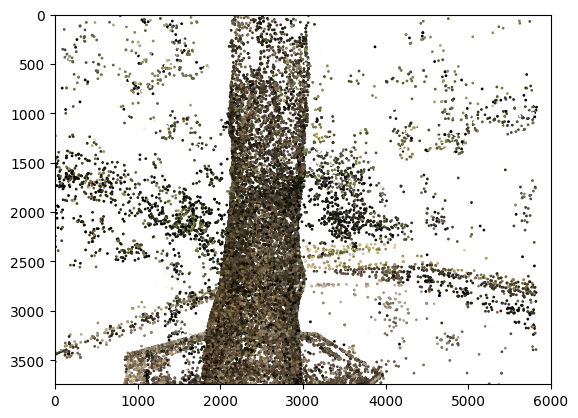

In [5]:
import matplotlib.pyplot as plt

plt.scatter(
    processed_gaussians.means_3d[:, 0].detach().cpu(),
    processed_gaussians.means_3d[:, 1].detach().cpu(),
    c=processed_gaussians.color.detach().cpu(),
    s=1,
)

plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis()

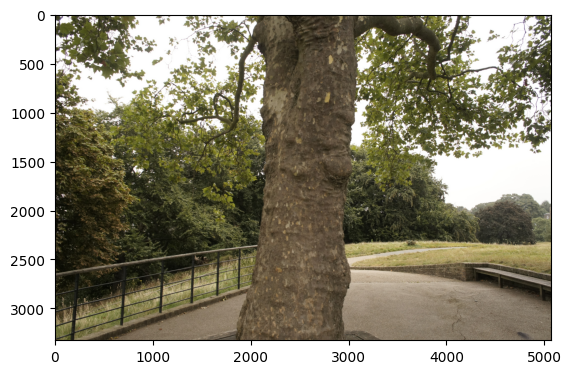

In [6]:
import PIL

image_path = "/Users/derek/Desktop/intro_to_gaussian_splatting/data/treehill/images/_DSC8973.JPG"
image = PIL.Image.open(image_path)

plt.imshow(image)


In [7]:
with torch.no_grad():
    output_image = scene.render(
        preprocessed_gaussians=processed_gaussians, height=height, width=width, tile_size=TILE_SIZE
    )

starting sum
ending sum


  7%|▋         | 13307/199612 [02:23<32:15, 96.24it/s] 

In [7]:
with torch.no_grad():
    output_image = scene.render_cuda(
        preprocessed_gaussians=processed_gaussians, height=height, width=width, tile_size=TILE_SIZE
    )

starting sum
ending sum
tensor(181152, device='cuda:0') 27333
317 208


IndexError: index 208 is out of bounds for dimension 1 with size 208

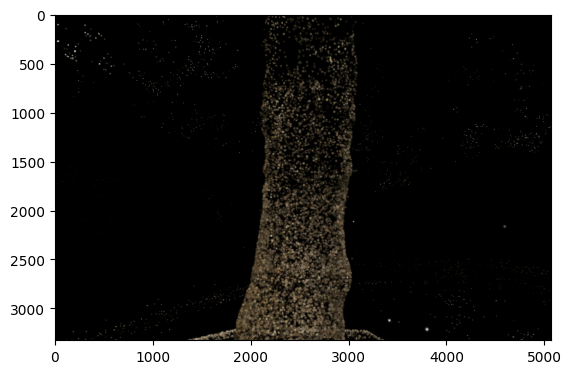

In [8]:
import matplotlib.pyplot as plt

plt.imshow(output_image.cpu().detach().transpose(0, 1))
plt.show()